In [1]:
import yaml
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import re
#import mplhep as hep
import math
import copy
import os
# os.chdir("/data1/DATA_SOWA/SALT_reg_studies")
from UT_Helper import *

- UT - 4192 chips 
- A-side - 2096 chips 
- C-side - 2096 chips
- UTaX - 992 chips (496x2)
- UTaU - 992 chips (496x2)
- UTbV - 1104 chips (552x2)
- UTbX - 1104 chips (552x2)



In [2]:
""" 
Loading some selected files. One of the files is a recipe and is also loaded as a benchmark for the other files. 
Because of sorting algorithm, it should always be stored as the last dictionary in the list

"""

# DIR_PATH = "/data1/DATA_SOWA/SALT_reg_studies/new_data/UT/"
# RECIPES = [DIR_PATH + f for f in os.listdir(DIR_PATH)]
# UT_ev = UT_evolution(RECIPES)

' \nLoading some selected files. One of the files is a recipe and is also loaded as a benchmark for the other files. \nBecause of sorting algorithm, it should always be stored as the last dictionary in the list\n\n'

In [3]:
# DIR_PATH = "/etude/sowrol/SALT_reg_studies/dump_files/new_dumps/2024/UT/"
# RECIPES = [DIR_PATH + "register_dump_20241031T163453T163451.txt"]
DIR_PATH = "/etude/sowrol/SALT_reg_studies/dump_files/new_dumps/2025/UT/"
RECIPES = [DIR_PATH + f for f in os.listdir(DIR_PATH)]
UT_ev = UT_evolution(RECIPES)

In [4]:
# Make a list with all links masked at the ECS level:
should_be_masked = []
# for fname in ['./disabled_links_a.txt','./disabled_links_c.txt']:
#     lines = fname
#     with open(fname) as infile:
#         for line in infile.readlines():
#             should_be_masked.append(line.split(",")[4])

fname = './disabled_0000313124.csv'
with open(fname) as infile:
    for line in infile.readlines():
        if ('AB' in line) or ('AT' in line):
            UT_side = 'UADAQFEE:'
        else:
            UT_side = 'UCDAQFEE:'
        
        should_be_masked.append(UT_side + line.split("\n")[0])



In [5]:
for i in range(UT_ev.nrecipes):
    for entry in should_be_masked:
        entry = entry.replace(":", ".")
        UT_side, UT_sector, UT_chip = entry.split(".")
        if UT_side in UT_ev.at(i).keys():
            if UT_sector in UT_ev.at(i)[UT_side].keys():
                if UT_chip in UT_ev.at(i)[UT_side][UT_sector].keys():
                    UT_ev.at(i)[UT_side][UT_sector][UT_chip]["masks_cfg"] = 128*[1]

In [282]:
df = pd.read_csv("/etude/sowrol/DecisionMaker/New_Vis_Tool/all_worst_309983.csv", index_col="ChannelID")

In [283]:
def add_register(register, subregister, start_bit, end_bit, twos_complement, index = -1):
    df[subregister] = np.nan
    for UT_side in UT_ev.at(index).keys():
        for UT_sector in UT_ev.at(index)[UT_side].keys():
            for UT_chip in UT_ev.at(index)[UT_side][UT_sector].keys():
                if register not in UT_ev.vector_regs:
                    val = UT_ev.at(index)[UT_side][UT_sector][UT_chip][register] 
                    dec_val = get_bits(int(val, 16), start_bit, end_bit, twos_complement)
                    init_chid = UT_ev.bi_translator[f"{UT_sector}.{UT_chip}.Ch0"]
                    end_chid = init_chid+127
                    df.loc[init_chid:end_chid, subregister] = dec_val
                else:
                    vals = UT_ev.at(index)[UT_side][UT_sector][UT_chip][register] 
                    dec_vals = [get_bits(int(val, 16), start_bit, end_bit, twos_complement) for val in vals]
                    init_chid = UT_ev.bi_translator[f"{UT_sector}.{UT_chip}.Ch0"]
                    end_chid = init_chid+127
                    df.loc[init_chid:end_chid, subregister] = dec_vals

In [284]:
def is_unique(register):
    s = df.loc[~np.isnan(df["amplitude"]), register].dropna()
    a = s.to_numpy() # s.values (pandas<0.24)
    return (a[0] == a).all()

### Global registers

In [285]:
add_register("clk_rst_tree_cfg", "reset_disable", start_bit = 3, end_bit = 4, twos_complement=False)
add_register("clk_rst_tree_cfg", "clock_disable", start_bit = 0, end_bit = 1, twos_complement=False)
add_register("glb_seu_cnt_reg", "glb_seu_cnt_reg", start_bit=0, end_bit=7, twos_complement=False)          # 0 everywhere
add_register("i2c_seu_cnt_reg", "i2c_seu_cnt_reg", start_bit=0, end_bit=7, twos_complement=False)

### Analogue and mixed mode registers

In [286]:
### ----------------------------- Exactly the same value for very ASIC ----------------------------------------#

add_register("ana_g_cfg", "set_del", start_bit=0, end_bit=2, twos_complement=False)
add_register("preamp_cfg", "preamp_dac", start_bit=0, end_bit=4, twos_complement=False)
add_register("shaper_cfg", "shaper_dac", start_bit=0, end_bit=4, twos_complement=False)
add_register("s2d_cfg", "s2d_dac", start_bit=0, end_bit=4, twos_complement=False)

### ------------------------------------------------------------------------------------------------------------
add_register("baseline_g_cfg", "baseline_g_cfg", start_bit=0, end_bit=7, twos_complement=False)           # 128 everywhere
add_register("baselines_cfg", "baselines_cfg", start_bit=0, end_bit=7, twos_complement=False)
add_register("tch_baseline0_cfg", "tch_baseline0_cfg", start_bit=0, end_bit=7, twos_complement=False)     # 128 everywhere
add_register("tch_baseline1_cfg", "tch_baseline1_cfg", start_bit=0, end_bit=7, twos_complement=False)     # 128 everywhere
add_register("ana_seu_cnt_reg", "ana_seu_cnt_reg", start_bit=0, end_bit=7, twos_complement=False)

### DSP registers

In [287]:
add_register("ped_g_cfg", "invert", start_bit=7, end_bit=7, twos_complement=False)
add_register("ped_g_cfg", "is_const", start_bit=6, end_bit=6, twos_complement=False)                      # 0 everywhere
add_register("ped_g_cfg", "const_value", start_bit=0, end_bit=5, twos_complement=True)                    # 0 everywhere
add_register("mcm_th_cfg", "mcm_th", start_bit=0, end_bit=5, twos_complement=True)
add_register("mcm_th2_cfg", "mcm_th2", start_bit=0, end_bit=5, twos_complement=True)                      # -32 for some ASICs - why? (log) 
add_register("n_zs_cfg", "nzs_sel", start_bit=5, end_bit=6, twos_complement=False)
add_register("pack_adc_sync_cfg", "adc_sync_sel", start_bit=7, end_bit=7, twos_complement=False)          # quite interesting
add_register("pack_adc_sync_cfg", "packet_types", start_bit=0, end_bit=2, twos_complement=False)          # same for every ASIC
add_register("zs_channels_cfg", "zs_channels_cfg", start_bit=0, end_bit=5, twos_complement=False)         # 63 everywhere
add_register("sync0_cfg", "sync0_cfg", start_bit=0, end_bit=7, twos_complement=False)                     # 245 everywhere
add_register("sync1_cfg", "sync1_cfg", start_bit=0, end_bit=7, twos_complement=False)                     # 15 everywhere
add_register("tch_data_cfg", "tch_data_cfg", start_bit=0, end_bit=7, twos_complement=False)               # 0 everywhere
add_register("dsp_seu_cnt_reg", "dsp_seu_cnt_reg", start_bit=0, end_bit=7, twos_complement=False)         # 0 everywhere
add_register("dsp_overflow_reg", "bxid_cnt_overflow_snap", start_bit=1, end_bit=1, twos_complement=False) # 1 everywhere
add_register("dsp_overflow_reg", "bxid_cnt_overflow", start_bit=0, end_bit=0, twos_complement=False)      # 1 everywhere
add_register("bxid_cnt_reg", "bxid_cnt0_reg", start_bit=0, end_bit=7, twos_complement=False) 
add_register("bxid_cnt_reg", "bxid_cnt1_reg", start_bit=8, end_bit=11, twos_complement=False) 
add_register("bxid_cnt_snap_reg", "bxid_cnt0_snap_reg", start_bit=0, end_bit=7, twos_complement=False) 
add_register("bxid_cnt_snap_reg", "bxid_cnt1_snap_reg", start_bit=8, end_bit=11, twos_complement=False) 

### Memory registers and counters

In [288]:
add_register("mem_pack_cfg", "mem_packet_types", start_bit=0, end_bit=1, twos_complement=False)          # same for every ASIC
add_register("elinks_cfg", "add_elinks", start_bit=0, end_bit=1, twos_complement=False)
add_register("idle_cfg", "idle_group_size", start_bit=0, end_bit=4, twos_complement=False)
add_register("mem_seu_cnt_reg", "mem_seu_cnt_reg", start_bit=0, end_bit=7, twos_complement=False)        # 0 everywhere
add_register("idle_cnt_reg", "idle_cnt0_reg", start_bit=0, end_bit=7, twos_complement=False)             # 0 everywhere
add_register("idle_cnt_reg", "idle_cnt1_reg", start_bit=8, end_bit=15, twos_complement=False) 
add_register("idle_cnt_reg", "idle_cnt2_reg", start_bit=16, end_bit=23, twos_complement=False) 
add_register("idle_cnt_reg", "idle_cnt3_reg", start_bit=24, end_bit=31, twos_complement=False) 
add_register("idle_cnt_reg", "idle_cnt4_reg", start_bit=32, end_bit=39, twos_complement=False) 
add_register("idle_cnt_reg", "idle_cnt5_reg", start_bit=40, end_bit=47, twos_complement=False) 
## snap to samo

### Serializer registers

In [289]:
add_register("ser_source_cfg", "counter_mode", start_bit=4, end_bit=5, twos_complement=False)            # 0 everywhere
add_register("ser_source_cfg", "short_loop", start_bit=3, end_bit=3, twos_complement=False)              # 0 everywhere
add_register("ser_source_cfg", "serial_input_sel", start_bit=0, end_bit=2, twos_complement=False)        # 0 everywhere
add_register("pattern_cfg", "pattern_cfg", start_bit=0, end_bit=7, twos_complement=False)                # 0 everywhere
add_register("deser_cfg", "deser_byte_start", start_bit=2, end_bit=4, twos_complement=False)
add_register("deser_cfg", "data_clk_sel", start_bit=0, end_bit=1, twos_complement=False)                 # ??????? why 3
add_register("pll_clk_cfg", "pll_clk_sel_1", start_bit=4, end_bit=7, twos_complement=False) 
add_register("pll_clk_cfg", "pll_clk_sel_0", start_bit=0, end_bit=3, twos_complement=False) 
add_register("pll_main_cfg", "pll_enable", start_bit=7, end_bit=7, twos_complement=False)                # 1 everywhere
add_register("pll_main_cfg", "pll_connect", start_bit=6, end_bit=6, twos_complement=False)               # 1 everywhere
add_register("pll_main_cfg", "pll_gain", start_bit=2, end_bit=3, twos_complement=False)                  # 1 everywhere
add_register("pll_cp_cfg", "pll_cp_cur", start_bit=0, end_bit=6, twos_complement=False)                  # 26 everywhere
add_register("pll_vco_cfg", "pll_vco_cfg", start_bit=0, end_bit=6, twos_complement=False)
add_register("tfc_fifo_cfg", "tfc_fifo_cfg", start_bit=0, end_bit=7, twos_complement=False)              # interesting
add_register("ser_g_cfg", "ser_byte_start", start_bit=0, end_bit=2, twos_complement=False)               # interesting
add_register("calib_fifo_cfg", "calib_fifo_cfg", start_bit=0, end_bit=7, twos_complement=False)          # 0 everywhere
add_register("ser_seu_cnt_reg", "ser_seu_cnt_reg", start_bit=0, end_bit=7, twos_complement=False)        # 0 everywhere

### Other configuration registers

In [290]:
add_register("others_g_cfg", "dll_start", start_bit=6, end_bit=6, twos_complement=False)                # 1 everywhere
add_register("others_g_cfg", "dll_connect", start_bit=5, end_bit=5, twos_complement=False)              # 1 everywhere
add_register("others_g_cfg", "slvs_termination", start_bit=4, end_bit=4, twos_complement=False)         # 0 everywhere
add_register("others_g_cfg", "adc_mon_off", start_bit=3, end_bit=3, twos_complement=False)              # 0 everywhere
add_register("dll_vcdl_cfg", "dll_vcdl_cfg", start_bit=0, end_bit=6, twos_complement=False) 
add_register("dll_cp_cfg", "dll_cp_cfg", start_bit=0, end_bit=6, twos_complement=False)                 # 26 everywhere
add_register("adc_clk_cfg", "adc_clk_sel", start_bit=0, end_bit=5, twos_complement=False) 
add_register("calib_clk_cfg", "calib_clk_sel", start_bit=0, end_bit=5, twos_complement=False)           # 0 everywhere
add_register("calib_main_cfg", "calib_inv", start_bit=7, end_bit=7, twos_complement=False) 
add_register("calib_main_cfg", "calib_neg_sync", start_bit=6, end_bit=6, twos_complement=False)         # 1 everywhere
add_register("calib_main_cfg", "calib_pulse_len", start_bit=0, end_bit=4, twos_complement=False)        # 20 everywhere
add_register("calib_volt_cfg", "calib_volt_dac", start_bit=0, end_bit=5, twos_complement=False)         # 12 everywhere
add_register("slvs_cur_cfg", "slvs_cur_dac", start_bit=0, end_bit=4, twos_complement=False)             # 13 everywhere
add_register("slvs_vcm_cfg", "slvs_vcm_dac", start_bit=0, end_bit=4, twos_complement=False)             # 10 everywhere
add_register("tch_calib_cfg", "tch_calib_enable_1", start_bit=1, end_bit=1, twos_complement=False)      # 0 everywhere
add_register("tch_calib_cfg", "tch_calib_enable_0", start_bit=0, end_bit=0, twos_complement=False)      # 0 everywhere
add_register("vcm_cur_cfg", "vcm_cur_cfg", start_bit=0, end_bit=5, twos_complement=False)
add_register("mon_cfg", "dll_mon_sel", start_bit=6, end_bit=7, twos_complement=False)                   # 0 everywhere
add_register("mon_cfg", "pll_mon_sel", start_bit=4, end_bit=5, twos_complement=False)
add_register("mon_cfg", "dac0_mon_sel", start_bit=0, end_bit=1, twos_complement=False)                  # 0 everywhere
add_register("other_seu_cnt_reg", "other_seu_cnt_reg", start_bit=0, end_bit=7, twos_complement=False)   # 0 everywhere
add_register("dll_vcdl_mon", "dll_vcdl_voltage", start_bit=0, end_bit=5, twos_complement=True)
add_register("pll_vco_mon", "pll_vco_voltage", start_bit=0, end_bit=5, twos_complement=True)
add_register("dll_hld_reg", "dll_hld_reg", start_bit=0, end_bit=2, twos_complement=False)               # 6 everywhere

### TFC counters

In [291]:
add_register("tfc_seu_cnt_reg", "tfc_seu_cnt_reg", start_bit=0, end_bit=7, twos_complement=False)      
add_register("tfc_overflow_reg", "tfc_overflow_reg", start_bit=0, end_bit=7, twos_complement=False)            # 32 everywhere
add_register("tfc_overflow_snap_reg", "tfc_overflow_snap_reg", start_bit=0, end_bit=7, twos_complement=False)  # 32 everywhere
add_register("calib_cnt_reg", "calib_cnt0_reg", start_bit=0, end_bit=7, twos_complement=False)                 # 0 everywhere
add_register("calib_cnt_reg", "calib_cnt1_reg", start_bit=8, end_bit=15, twos_complement=False)                # 0 everywhere
add_register("calib_cnt_reg", "calib_cnt2_reg", start_bit=16, end_bit=23, twos_complement=False)                
add_register("calib_cnt_reg", "calib_cnt3_reg", start_bit=24, end_bit=31, twos_complement=False)                
## snap takie samo
add_register("sync_cnt_reg", "sync_cnt0_reg", start_bit=0, end_bit=7, twos_complement=False)                   # 0 everywhere
add_register("sync_cnt_reg", "sync_cnt1_reg", start_bit=8, end_bit=15, twos_complement=False)                  # 0 everywhere
add_register("sync_cnt_reg", "sync_cnt2_reg", start_bit=16, end_bit=23, twos_complement=False)                 # 0 everywhere
add_register("sync_cnt_reg", "sync_cnt3_reg", start_bit=24, end_bit=31, twos_complement=False)                  
## snap takie samo
add_register("snapshot_cnt_reg", "snapshot_cnt0_reg", start_bit=0, end_bit=7, twos_complement=False)            
add_register("snapshot_cnt_reg", "snapshot_cnt1_reg", start_bit=8, end_bit=15, twos_complement=False)          
add_register("snapshot_cnt_reg", "snapshot_cnt2_reg", start_bit=16, end_bit=23, twos_complement=False)                  
add_register("snapshot_cnt_reg", "snapshot_cnt3_reg", start_bit=24, end_bit=31, twos_complement=False)                 
## snap takie samo
add_register("bxveto_cnt_reg", "bxveto_cnt0_reg", start_bit=0, end_bit=7, twos_complement=False)               # 0 everywhere
add_register("bxveto_cnt_reg", "bxveto_cnt1_reg", start_bit=8, end_bit=15, twos_complement=False)                  
add_register("bxveto_cnt_reg", "bxveto_cnt2_reg", start_bit=16, end_bit=23, twos_complement=False)             
add_register("bxveto_cnt_reg", "bxveto_cnt3_reg", start_bit=24, end_bit=31, twos_complement=False)               
add_register("bxveto_cnt_reg", "bxveto_cnt4_reg", start_bit=32, end_bit=39, twos_complement=False)                
add_register("bxveto_cnt_reg", "bxveto_cnt5_reg", start_bit=40, end_bit=47, twos_complement=False)                 
## snap takie samo
add_register("nzs_cnt_reg", "nzs_cnt0_reg", start_bit=0, end_bit=7, twos_complement=False)                     # 0 everywhere
add_register("nzs_cnt_reg", "nzs_cnt1_reg", start_bit=8, end_bit=15, twos_complement=False)                    # 0 everywhere
add_register("nzs_cnt_reg", "nzs_cnt2_reg", start_bit=16, end_bit=23, twos_complement=False)                 
add_register("nzs_cnt_reg", "nzs_cnt3_reg", start_bit=24, end_bit=31, twos_complement=False)                  
## snap takie samo
add_register("header_cnt_reg", "header_cnt0_reg", start_bit=0, end_bit=7, twos_complement=False)               # 0 everywhere
add_register("header_cnt_reg", "header_cnt1_reg", start_bit=8, end_bit=15, twos_complement=False)                  
add_register("header_cnt_reg", "header_cnt2_reg", start_bit=16, end_bit=23, twos_complement=False)             
add_register("header_cnt_reg", "header_cnt3_reg", start_bit=24, end_bit=31, twos_complement=False)               
add_register("header_cnt_reg", "header_cnt4_reg", start_bit=32, end_bit=39, twos_complement=False)                
add_register("header_cnt_reg", "header_cnt5_reg", start_bit=40, end_bit=47, twos_complement=False)        
## snap takie samo
add_register("fereset_cnt_reg", "fereset_cnt0_reg", start_bit=0, end_bit=7, twos_complement=False)             # 0 everywhere
add_register("fereset_cnt_reg", "fereset_cnt1_reg", start_bit=8, end_bit=15, twos_complement=False)            # 0 everywhere
add_register("fereset_cnt_reg", "fereset_cnt2_reg", start_bit=16, end_bit=23, twos_complement=False)           # 0 everywhere
add_register("fereset_cnt_reg", "fereset_cnt3_reg", start_bit=24, end_bit=31, twos_complement=False)                  
## snap takie samo
add_register("bxreset_cnt_reg", "bxreset_cnt0_reg", start_bit=0, end_bit=7, twos_complement=False)             # 0 everywhere
add_register("bxreset_cnt_reg", "bxreset_cnt1_reg", start_bit=8, end_bit=15, twos_complement=False)                  
add_register("bxreset_cnt_reg", "bxreset_cnt2_reg", start_bit=16, end_bit=23, twos_complement=False)                 
add_register("bxreset_cnt_reg", "bxreset_cnt3_reg", start_bit=24, end_bit=31, twos_complement=False)                  
## snap takie samo

/tmp/ipykernel_2322543/2224540095.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[subregister] = np.nan
/tmp/ipykernel_2322543/2224540095.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[subregister] = np.nan
/tmp/ipykernel_2322543/2224540095.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

In [292]:
columns_to_drop = []
for column in df.columns:
    if is_unique(column):
        columns_to_drop.append(column)
df.drop(columns=columns_to_drop, inplace=True)

In [293]:
i = 6
available_amplitudes = np.unique(df["amplitude"].to_numpy())
available_amplitudes = available_amplitudes[~np.isnan(available_amplitudes)]
available_amplitudes

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [351]:
only_staves_1_and_2 = False
register = df.columns[i]
i+=1
left_edge = df.loc[~np.isnan(df["amplitude"]), register].min()-0.5
right_edge = df.loc[~np.isnan(df["amplitude"]), register].max()+0.5
range = (left_edge, right_edge)
nbins = int(round(right_edge - left_edge))
stave_condition = "(ECS.str.contains('1A') | ECS.str.contains('2A') | ECS.str.contains('1C') | ECS.str.contains('2C'))"

fig, axs = plt.subplots(len(available_amplitudes), 1, figsize = (6,3*len(available_amplitudes)))
fig.suptitle(register, fontsize=20, y = 0.91)
for ax, amplitude in zip(axs, available_amplitudes):
    # ax.set_yscale("log")
    if only_staves_1_and_2:
        df.query(f"amplitude == {amplitude} & {stave_condition}").hist(register, ax=ax, range=range, bins = nbins)#, range=(31.5, 56.5), bins = 25)
    else:
        df.query(f"amplitude == {amplitude}").hist(register, ax=ax, range = range, bins=nbins)#, range=(31.5, 56.5), bins = 25)
    ax.set_title(f"amplitude = {amplitude}")

IndexError: index 63 is out of bounds for axis 0 with size 63

array([[<Axes: title={'center': 'vcm_cur_cfg'}>]], dtype=object)

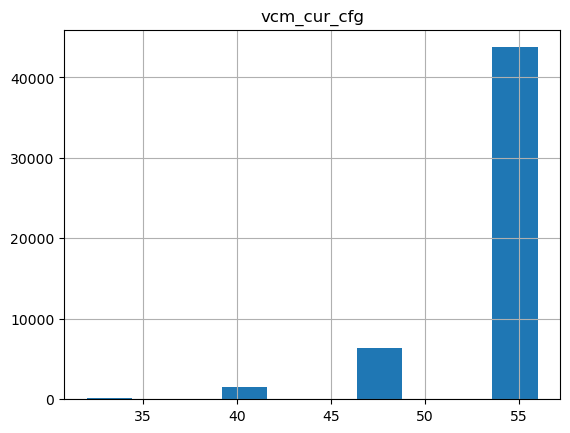

In [44]:
amplitude = 0
df.query(f"amplitude == {amplitude}").hist("vcm_cur_cfg")

In [21]:
def add_register(row, register, start_bit, end_bit, twos_complement, index = -1):
    if row.UT_side not in UT_ev.at(index).keys():
        return np.nan
    elif row.ECS not in UT_ev.at(index)[row.UT_side].keys():
        return np.nan
    elif row.Chip not in UT_ev.at(index)[row.UT_side][row.ECS].keys():
        return np.nan
    else:
        val = UT_ev.at(index)[row.UT_side][row.ECS][row.Chip][register]
        return get_bits(int(val, 16), start_bit, end_bit, twos_complement)

In [ ]:
register = "vcm_cur_cfg"
df[register] = df.apply(add_register, axis = 1, register = register, start_bit=0, end_bit=5, twos_complement=False)

UT_side           ECS   Chip  amplitude  vcm_cur_cfg
0     UADAQFEE   UTaX_3AB_M3  Chip2        7.0         56.0
1     UADAQFEE  UTaX_2AB_M1W  Chip0        7.0         56.0
2     UADAQFEE   UTaX_3AB_M4  Chip2        7.0         56.0
3     UADAQFEE   UTbX_2AT_M2  Chip0        7.0         56.0
4     UADAQFEE  UTbV_2AT_M1W  Chip0        7.0         48.0
...        ...           ...    ...        ...          ...
4187  UADAQFEE   UTbX_9AB_M2  Chip1        NaN         56.0
4188  UADAQFEE   UTbX_9AB_M2  Chip2        NaN         56.0
4189  UADAQFEE   UTbX_9AB_M2  Chip3        NaN         56.0
4190  UADAQFEE   UTbX_9AB_S1  Chip3        NaN         32.0
4191  UADAQFEE   UTbX_9AT_S1  Chip1        NaN         32.0

[4192 rows x 5 columns]

In [27]:
df.index.values

array([   0,    1,    2, ..., 4189, 4190, 4191])

(-0.5, 29.5)

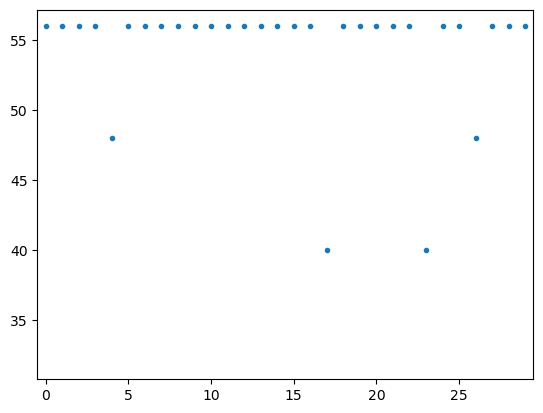

In [36]:
NWORST = 30
fig, ax = plt.subplots()
ax.plot(df.index, df[register], '.')
ax.set_xlim([-0.5,NWORST-0.5])